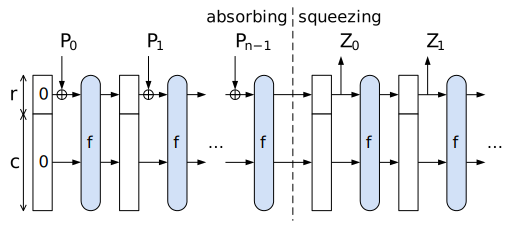

In [1]:
from IPython.display import SVG, display
display(SVG(url="https://upload.wikimedia.org/wikipedia/commons/7/70/SpongeConstruction.svg"))

A sponge function is built from three components:

* State, containing $b$ bits,

* a function $f:{0,1}^{|bits|} -> {0,1}^|bits|$ that transforms the state memory (often it is a pseudorandom permutation of the $2^{|bits|}$ state values)

* a padding function $P$


The State memory is divided into two sections: Bitrate $R$ ($r$ bits) and the remaining part the Capacity $C$ contains $b-r$ bits.

Pad appends enough bits to the input string so that the length of the padded input is a whole multiple of R. The padded input can thus be broken into $r$-bit blocks.

The sponge function operates as follows:

* State is initialized to zero

* The input string is padded. This means the input is transformed into blocks of |r| bits using Pad.
    
* for each |r|-bit Block of the padded input:
    * R is replaced with Bitrate XOR Block (using bitwise XOR)
    * State is replaced by f(State)

In [99]:
from typing import Callable
from zkp_playground.algorithms import bits_little_endian_from_bytes, bytes_from_bits_little_endian


class Sponge:
    
    def __init__(self, b, r, f=lambda x: x[::-1]):
        assert b % 8 == 0
        assert b - r >= 8
        self.f = f
        self.b = b
        self.r = r
        self.R = [int(i) for i in "0"*r]
        self.C = [int(i) for i in "0"*(b-r)]
        
    @property
    def S(self):
        return self.R + self.C
    
    @S.setter
    def S(self, v):
        self.R = v[:self.r]
        self.C = v[self.r:]
    
    @classmethod
    def padding(cls, dataset: bytes, r: int):
        dataset = [int(i) for i in bits_little_endian_from_bytes(dataset)]
        print(dataset)
        left = len(dataset) % (r)
        if left != 0:
            dataset = list(dataset) + [0] * (r - left)
        assert len(dataset) % (r) == 0
        return dataset

    def absorbs(self, dataset: bytes):
        dataset = self.padding(dataset, self.r)
        for i in range(0, len(dataset) // self.r):
            m = dataset[i*self.r: i*self.r+self.r]
            for i in range(0, self.r):
                self.R[i] ^= m[i]
            self.S = self.f(self.S)
            
    def squeezed(self, length):
        ret = []
        for i in range((length // self.r)+1):
            ret = ret + self.R
            self.S = self.f(self.S)
        ret = "".join([str(i) for i in ret])
        return bytes_from_bits_little_endian(ret)[:length]
            
        
    
    
    
    